In [61]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt

In [62]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg11', pretrained=True)
model.eval()

Using cache found in C:\Users\Yi Wen/.cache\torch\hub\pytorch_vision_v0.9.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [63]:
# Load data: if Windows
path='Image/All_Cropped'

images={}

directory=['Mountain', 'Beach', 
           'Mug', 'Banana', 
           'Car', 'Plane', 
           'Lighthouse', 'Church']

for dir in directory:
    images[dir]=[file for file in os.listdir(path+'/'+dir) if file.endswith(('jpeg', 'jpg'))]

In [64]:
for key in images.keys():
    print(key, ":", len(images[key]))

Mountain : 16
Beach : 16
Mug : 16
Banana : 16
Car : 16
Plane : 16
Lighthouse : 16
Church : 16


Compute mean and std of all images

In [65]:
preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
])
all_images = []
for cate, filename in images.items():
    for f in filename:
        dir=os.path.join(path,cate,f)
        img=preprocess(Image.open(dir))
#         if img.shape[1] != 256 or img.shape[2] != 256:
#             print(img.shape)
#             plt.imshow(Image.open(dir))
#             plt.show()
        all_images.append(img)
all_images = torch.stack(all_images).numpy()
print(all_images.shape)
mean = np.mean(all_images, axis=(0,2,3))
std = np.std(all_images, axis=(0,2,3))

(128, 3, 256, 256)


In [66]:
mean

array([0.55640996, 0.5760121 , 0.56940985], dtype=float32)

In [67]:
std

array([0.3011326 , 0.28208593, 0.31378052], dtype=float32)

In [68]:
# preprocess = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std),
# ])
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [69]:
#type prob cate+filename
all_img={'type':[], 'typicality_score': [], 'dir':[],'top5_labels':[]}

In [70]:
# read labels 
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [71]:
for cate, filename in images.items():
    for f in filename:
        dir=os.path.join(path,cate,f)
        img=Image.open(dir)
        #print(dir)
        input_tensor=preprocess(img)
        input_batch = input_tensor.unsqueeze(0)

        if torch.cuda.is_available():
            input_batch= input_batch.to('cuda')
            model.to('cuda')

        with torch.no_grad():
            output = model(input_batch)
        
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        typ_score=round(float(probabilities.max()*100),1)
        
        # Show top categories per image
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        temp = {}
        for i in range(top5_prob.size(0)):
            temp[categories[top5_catid[i]]] = top5_prob[i].item()

        all_img['dir'].append(dir)
        all_img['typicality_score'].append(typ_score)
        all_img['top5_labels'].append(temp)
        if 'Mountain' in cate:
            all_img['type'].append('Mountain')
        if 'Beach' in cate:
            all_img['type'].append('Beach')
        if 'Mug' in cate:
            all_img['type'].append('Mug')
        if 'Banana' in cate:
            all_img['type'].append('Banana')
        if 'Car' in cate:
            all_img['type'].append('Car')
        if 'Plane' in cate:
            all_img['type'].append('Plane')
        if 'Lighthouse' in cate:
            all_img['type'].append('Lighthouse')
        if 'Church' in cate:
            all_img['type'].append('Church')

#         print('Typicality of ',f, ' = ',probabilities.max()*100)

In [72]:
all_img_df=pd.DataFrame(all_img)

In [73]:
all_img_df['label'] = all_img_df['top5_labels'].apply(lambda x: list(x.keys())[0])

In [74]:
all_img_df['7_score']=round(all_img_df['typicality_score']*7/100,1)
all_img_df.head()

,type,typicality_score,dir,top5_labels,label,7_score
0,Mountain,33.9,Image/All_Cropped\Mountain\1.jpg,"{'lakeside': 0.33909276127815247, 'valley': 0....",lakeside,2.4
1,Mountain,38.0,Image/All_Cropped\Mountain\10.jpg,"{'valley': 0.38023269176483154, 'alp': 0.21241...",valley,2.7
2,Mountain,69.5,Image/All_Cropped\Mountain\11.jpg,"{'alp': 0.6954638361930847, 'volcano': 0.18501...",alp,4.9
3,Mountain,59.0,Image/All_Cropped\Mountain\12.jpg,"{'alp': 0.5897970795631409, 'valley': 0.335895...",alp,4.1
4,Mountain,49.9,Image/All_Cropped\Mountain\13.jpg,"{'cliff': 0.49911436438560486, 'promontory': 0...",cliff,3.5


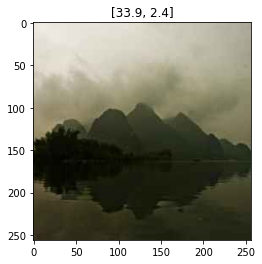

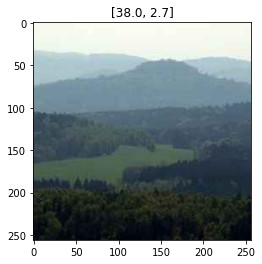

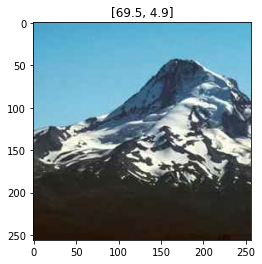

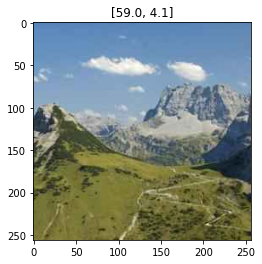

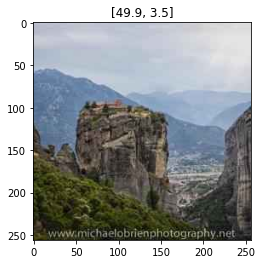

In [75]:
score=[]
for i in range(5):
    dir=all_img_df['dir'][i]
    score.append([all_img_df['typicality_score'][i], all_img_df['7_score'][i]])
    img=Image.open(dir)
    plt.imshow(img)
    plt.title(score[i])
    plt.show()

In [76]:
all_img_df.to_csv('vgg_scores.csv')

(array([2., 1., 0., 2., 3., 3., 0., 2., 0., 3.]),
 array([21.9 , 27.58, 33.26, 38.94, 44.62, 50.3 , 55.98, 61.66, 67.34,
        73.02, 78.7 ]),
 <BarContainer object of 10 artists>)

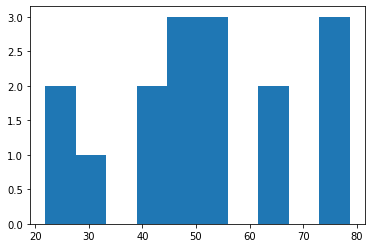

In [77]:
import matplotlib.pyplot as plt

mount=all_img_df[all_img_df['type']=='Beach']
plt.hist(mount['typicality_score'])

## Filter for top labels

## Layer versus correlation

In [ ]:
# access score at each layer